In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Классификация текста

Одной из широко используемых задач NLP в различных бизнес-задачах является “классификация текста”. Цель классификации текста состоит в том, чтобы автоматически классифицировать текстовые документы по одной или нескольким определенным категориям. Некоторые примеры классификации текста:
- Определение настроений аудитории из социальных сетей
- Обнаружение спама и нежелательных писем
- Автоматическая маркировка запросов клиентов
- Категоризация новостных статей по определенным темам

В данной работе я буду использовать классификацию для разметки отзывов (проставления рейтингов отзывам), чтобы можно было оперативно на основании рейтингов улавливать отношение к товару у большинства, анализ тональности. И дальше работать с отзывами в связи с запросами бизнеса.

Классификация текста является примером задачи машинного обучения с учителем, поскольку для обучения классификатора используется помеченный набор данных, содержащий текстовые документы и их метки. Пайплайн классификации текста состоит из 4 основных частей:
1. Подготовка данных
2. Генерация признаков
3. Тренировка модели
4. Оценка и тюнинг модели

Классификацию отзывов хочу проделать через анализ тональности, косинусное расстояние, частотный анализ, и прогнозирование через модели sklearn (в частности линейной регрессии.

In [2]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, ensemble
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import nltk
nltk.download('all')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
import pandas, numpy, textblob, string
#!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

In [3]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/Нейросетевое_моделирование_РАНХИГС/DatafinitiElectronicsProductData.csv")

In [4]:
data.head(2)

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,imageURLs,keys,manufacturer,manufacturerNumber,name,primaryCategories,reviews.date,reviews.dateSeen,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,upc,weight
0,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,microsoftsurfacepro4typecoverwithfingerprintid...,Microsoft,RH7-00001,Microsoft Surface Pro 4 Type Cover with Finger...,Electronics,2015-12-04T00:00:00.000Z,"2017-09-03T00:00:00Z,2017-08-27T00:00:00Z,2017...",True,0.0,5.0,http://reviews.bestbuy.com/3545/4562009/review...,"This keyboard is very easy to type on, but the...",Love the fingerprint reader,JNH1,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds
1,AVpf3txeLJeJML43FN82,B0168YIWSI,Microsoft,"Electronics,Computers,Computer Accessories,Key...",Black,2015-11-13T12:28:09Z,2018-01-29T02:15:13Z,11.6 in x 8.5 in x 0.19 in,8.900000e+11,https://i5.walmartimages.com/asr/2a41f6f0-844e...,microsoftsurfacepro4typecoverwithfingerprintid...,Microsoft,RH7-00001,Microsoft Surface Pro 4 Type Cover with Finger...,Electronics,2015-12-04T00:00:00.000Z,"2017-09-03T00:00:00Z,2017-08-27T00:00:00Z,2017...",True,0.0,4.0,http://reviews.bestbuy.com/3545/4562009/review...,It's thin and light. I can type pretty easily ...,Nice,Appa,https://www.walmart.com/ip/Microsoft-Surface-P...,8.900000e+11,1.1 pounds


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7299 entries, 0 to 7298
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   7299 non-null   object 
 1   asins                7299 non-null   object 
 2   brand                7299 non-null   object 
 3   categories           7299 non-null   object 
 4   colors               5280 non-null   object 
 5   dateAdded            7299 non-null   object 
 6   dateUpdated          7299 non-null   object 
 7   dimension            6090 non-null   object 
 8   ean                  2951 non-null   float64
 9   imageURLs            7299 non-null   object 
 10  keys                 7299 non-null   object 
 11  manufacturer         4632 non-null   object 
 12  manufacturerNumber   7299 non-null   object 
 13  name                 7299 non-null   object 
 14  primaryCategories    7299 non-null   object 
 15  reviews.date         7238 non-null   o

In [6]:
df= pd.DataFrame(data[['brand', 'name', 'primaryCategories','reviews.text', 'sourceURLs', 'imageURLs', 'reviews.rating']])

In [7]:
df.head()

,brand,name,primaryCategories,reviews.text,sourceURLs,imageURLs,reviews.rating
0,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,Electronics,"This keyboard is very easy to type on, but the...",https://www.walmart.com/ip/Microsoft-Surface-P...,https://i5.walmartimages.com/asr/2a41f6f0-844e...,5.0
1,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,Electronics,It's thin and light. I can type pretty easily ...,https://www.walmart.com/ip/Microsoft-Surface-P...,https://i5.walmartimages.com/asr/2a41f6f0-844e...,4.0
2,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,Electronics,I love the new design the keys are spaced well...,https://www.walmart.com/ip/Microsoft-Surface-P...,https://i5.walmartimages.com/asr/2a41f6f0-844e...,4.0
3,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,Electronics,Attached easily and firmly. Has a nice feel. A...,https://www.walmart.com/ip/Microsoft-Surface-P...,https://i5.walmartimages.com/asr/2a41f6f0-844e...,5.0
4,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,Electronics,"Our original keyboard was okay, but did not ha...",https://www.walmart.com/ip/Microsoft-Surface-P...,https://i5.walmartimages.com/asr/2a41f6f0-844e...,5.0


In [8]:
df['reviews.rating'].value_counts()

5.0    4492
4.0    1663
3.0     440
1.0     318
2.0     222
Name: reviews.rating, dtype: int64

In [9]:
df['name'].value_counts()

Logitech 915-000224  Harmony Ultimate One 15-Device Universal Infrared Remote with Customizable Touch Screen Control - Black         1604
Microsoft Surface Pro 4 Type Cover with Fingerprint ID                                                                                507
Sony SRSXB30/BLK XB30 Portable Wireless Speaker with Bluetooth                                                                        477
Everest Elite 700 Around-Ear Wireless Headphones (White)                                                                              357
Slingbox M2                                                                                                                           342
SAMSUNG 40'' Class FHD (1080P) Smart LED TV (UN40M5300)                                                                               340
Alpine - 6-1/2" 2-Way Coaxial Car Speakers with Polypropylene Cones (Pair) - Black                                                    270
PNY Anarchy 16GB Kit (2x8GB) DDR4 

In [10]:
df.isna().sum()

brand                  0
name                   0
primaryCategories      0
reviews.text           5
sourceURLs             0
imageURLs              0
reviews.rating       164
dtype: int64

In [11]:
df.dropna(inplace= True)

In [12]:
df.isna().sum()

brand                0
name                 0
primaryCategories    0
reviews.text         0
sourceURLs           0
imageURLs            0
reviews.rating       0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7130 entries, 0 to 7298
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              7130 non-null   object 
 1   name               7130 non-null   object 
 2   primaryCategories  7130 non-null   object 
 3   reviews.text       7130 non-null   object 
 4   sourceURLs         7130 non-null   object 
 5   imageURLs          7130 non-null   object 
 6   reviews.rating     7130 non-null   float64
dtypes: float64(1), object(6)
memory usage: 445.6+ KB


In [14]:
df_reviews = df['reviews.text']
df_reviews

0       This keyboard is very easy to type on, but the...
1       It's thin and light. I can type pretty easily ...
2       I love the new design the keys are spaced well...
3       Attached easily and firmly. Has a nice feel. A...
4       Our original keyboard was okay, but did not ha...
                              ...                        
7294    This remote was a decent replacement for my lo...
7295    This looks good on my celling. Flushes very we...
7296    Great Plate for projector mount, very easy to ...
7297    This mount worked very well for me when I used...
7298    It's a nice solid mounting plate check and mak...
Name: reviews.text, Length: 7130, dtype: object

### Анализ тональности

Другая задача NLP - анализ тональности текста. Анализ тональности - определение полярности эмоциональных оценок в исследуемом тексте, который содержит мнения, суждения, эмоции, отношение автора к сущностям, личностям, вопросам, событиям, темам и их атрибутам.

С помощью SentimentIntensityAnalyzer определим тональность отзывов.

Ниже увидим, что SentimentIntensityAnalyzer не дает существенного инструментария для классификации отзывов по рейтингам.

In [15]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
df['sent_analysis'] = df['reviews.text'].apply(sid.polarity_scores)
df['sent_analysis']

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


0       {'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...
1       {'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...
2       {'neg': 0.068, 'neu': 0.647, 'pos': 0.285, 'co...
3       {'neg': 0.0, 'neu': 0.658, 'pos': 0.342, 'comp...
4       {'neg': 0.0, 'neu': 0.839, 'pos': 0.161, 'comp...
                              ...                        
7294    {'neg': 0.035, 'neu': 0.732, 'pos': 0.233, 'co...
7295    {'neg': 0.0, 'neu': 0.654, 'pos': 0.346, 'comp...
7296    {'neg': 0.0, 'neu': 0.49, 'pos': 0.51, 'compou...
7297    {'neg': 0.0, 'neu': 0.822, 'pos': 0.178, 'comp...
7298    {'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'comp...
Name: sent_analysis, Length: 7130, dtype: object

In [16]:
df['reviews.text'][1001]

'Bought this for an older Macbook. It wirked great.'

In [17]:
df['reviews.rating'][1001]

5.0

In [18]:
df['sent_analysis'][1001]

{'compound': 0.6249, 'neg': 0.0, 'neu': 0.661, 'pos': 0.339}

In [19]:
df.loc[[1001]]

,brand,name,primaryCategories,reviews.text,sourceURLs,imageURLs,reviews.rating,sent_analysis
1001,Corsair,Corsair CMSA8GX3M2A1066C7 Apple 8 GB Dual Chan...,Electronics,Bought this for an older Macbook. It wirked gr...,https://www.amazon.com/Corsair-CMSA8GX3M2A1066...,https://images-na.ssl-images-amazon.com/images...,5.0,"{'neg': 0.0, 'neu': 0.661, 'pos': 0.339, 'comp..."


In [20]:
df['imageURLs'][1001]

'https://images-na.ssl-images-amazon.com/images/I/811CuyZ6WBL._SL1500_.jpg,https://i5.walmartimages.com/asr/8d1b1f2d-7857-4e3e-8314-be0bbf94472c_1.b425257c6ea528b0beb2c971fd6d417a.jpeg?odnHeight=450&odnWidth=450&odnBg=FFFFFF,https://images-na.ssl-images-amazon.com/images/I/81ljo4XTqqL._SL1500_.jpg,https://i5.walmartimages.com/asr/869ef06a-7e1e-4d5d-a5eb-e09dda200663_1.cdefacd912e6b2e5346d3d48dd7c66b7.jpeg?odnHeight=450&odnWidth=450&odnBg=FFFFFF,https://i5.walmartimages.com/asr/dfdf41f0-8079-49b7-a4b3-7ff2a8dc1e46_1.d45be767246f90f331da7bc3fe533b2d.jpeg?odnHeight=450&odnWidth=450&odnBg=FFFFFF,https://i5.walmartimages.com/asr/445f2469-792a-49c9-87ba-ac7ac354a645_1.77d9969c44244b9c9a6eebd88ba3c529.jpeg?odnHeight=450&odnWidth=450&odnBg=FFFFFF,https://i5.walmartimages.com/asr/77a4df90-a7d8-4892-a016-52fa480875de_1.8ecb1506d20edf317f0064c5734d627e.jpeg?odnHeight=450&odnWidth=450&odnBg=FFFFFF,https://i5.walmartimages.com/asr/77537fa5-a12c-4737-b789-d35eb3139b2a_1.6cd6e69e111a853898068d9d5b02b

In [21]:
def apply_sentiment_compound(sent_analysis):
     return sent_analysis['compound']

df['sentiment_compound'] = df['sent_analysis'].apply(apply_sentiment_compound)


In [22]:
df[abs(df['sentiment_compound'])<0.6].head(3)

,brand,name,primaryCategories,reviews.text,sourceURLs,imageURLs,reviews.rating,sent_analysis,sentiment_compound
4,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,Electronics,"Our original keyboard was okay, but did not ha...",https://www.walmart.com/ip/Microsoft-Surface-P...,https://i5.walmartimages.com/asr/2a41f6f0-844e...,5.0,"{'neg': 0.0, 'neu': 0.839, 'pos': 0.161, 'comp...",0.4588
6,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,Electronics,I find it very comfortable to type with it but...,https://www.walmart.com/ip/Microsoft-Surface-P...,https://i5.walmartimages.com/asr/2a41f6f0-844e...,4.0,"{'neg': 0.0, 'neu': 0.85, 'pos': 0.15, 'compou...",0.3174
9,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,Electronics,I can now quickly and hassle free log into my ...,https://www.walmart.com/ip/Microsoft-Surface-P...,https://i5.walmartimages.com/asr/2a41f6f0-844e...,5.0,"{'neg': 0.113, 'neu': 0.759, 'pos': 0.129, 'co...",0.1779


In [23]:
import warnings
warnings.filterwarnings("ignore")

#### Подготовка датасета

В качестве датасета возьмем набор данных отзывов из маркетплейсов reviews в категории электроника. Набор данных состоит из 7 тыс текстовых отзывов и проставленных рейтингов. Обучаться и тренироваться будем на отзывах с проставленными рейтингами. Датасет содержит 'reviews.text' текст отзыва и 'reviews.rating' проставленный рейтинг товарам.

#### Предобработка текста

Сделаем некоторую базовую предобработку текста: 
- уберем апострофы
- уберем специальные символы
- приведем к нижнему регистру
- сделаем токенизацию
- уберем стоп-слова 
- сделаем лемматизацию

In [24]:
def removeApostrophe(review):
    review = review.lower()
    review = re.sub(r"won't", "will not", review)
    review = re.sub(r"can\'t", "can not", review)
    review = re.sub(r"n\'t", " not", review)
    review = re.sub(r"\'re", " are", review)
    review = re.sub(r"\'s", " is", review)
    review = re.sub(r"\'d", " would", review)
    review = re.sub(r"\'ll", " will", review)
    review = re.sub(r"\'t", " not", review)
    review = re.sub(r"\'ve", " have", review)
    review = re.sub(r"\'m", " am", review)
    return review

def removeApostropheFixed(review):
    review = review.lower()
    review = re.sub(r"not", "_not", review)
    review = re.sub(r"nor", "_nor", review)
    review = re.sub(r"no", "_no", review)
    review = re.sub(r"won't", "willnot", review)
    review = re.sub(r"can\'t", "cannot", review)
    review = re.sub(r"\snot", "not", review)
    review = re.sub(r"n\'t", "not", review)
    review = re.sub(r"\'re", " are", review)
    review = re.sub(r"\'s", " is", review)
    review = re.sub(r"\'d", " would", review)
    review = re.sub(r"\'ll", " will", review)
    review = re.sub(r"\'t", "_not", review)
    review = re.sub(r"\'ve", " have", review)
    review = re.sub(r"\'m", " am", review)
    review = re.sub(r"_{2,}", "_", review)
    return review

def removeSpecialChars(review):
     return re.sub('[^_a-zA-Z]', ' ', review)
    
def doCleaningFixed(review):
    review = removeApostropheFixed(review)
    review = removeSpecialChars(review) 
    review = review.lower()
    review = review.split() #Tokenization
    lmtzr = WordNetLemmatizer()
    review = [lmtzr.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review = " ".join(review)    
    return review

def doCleaning(review):
    review = removeApostrophe(review)
    review = removeSpecialChars(review) 
    review = review.lower() 
    review = review.split() #Tokenization
    lmtzr = WordNetLemmatizer()
    review = [lmtzr.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review = " ".join(review)    
    return review

In [25]:
# stopwords.words('english')

In [26]:
text = "Not I won't fdfd \'m  ase\'re can\'t this won't shouldn't"
print(text.lower(), ' = text.lower()')
print(removeApostropheFixed(text), ' = removeApostropheFixed(text)')
print(doCleaningFixed(removeApostropheFixed(text)), ' = doCleaningFixed(removeApostropheFixed(text))')

not i won't fdfd 'm  ase're can't this won't shouldn't  = text.lower()
_not i willnot fdfd  am  ase are cannot this willnot shouldnot  = removeApostropheFixed(text)
_not will_not fdfd ase can_not will_not should_not  = doCleaningFixed(removeApostropheFixed(text))


In [27]:
df['textOld'] = df['reviews.text'].apply(doCleaning)
df['textNew'] = df['reviews.text'].apply(doCleaningFixed)

In [28]:
# df['textOld'].head(20)

In [29]:
# df['textNew'].head(20)

In [30]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['textNew'], df['reviews.rating'], test_size=0.33, random_state=42)

In [31]:
# df[df['reviews.rating'].notna()].info()

#### Feature Engineering

На этом этапе необработанные текстовые данные будут преобразованы в векторы признаков, а новые признаки будут созданы с использованием существующего набора данных. Мы реализуем следующие идеи, чтобы получить релевантные признаки из нашего набора данных:

- Count вектора как признаки
- TF-IDF вектора как признаки
  - Word level
  - N-Gram level
  - Character level
- Word2Vect вектора как признаки 


### Count Vectors
Count Vector - это матричная нотация набора данных, в которой каждая строка представляет документ из корпуса, каждый столбец представляет термин из корпуса, а каждая ячейка представляет счетчик частот конкретного термина в конкретном документе.

In [32]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', min_df=1, max_df=0.8)#, max_features=5000)
count_vect.fit(df['textNew'])
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

##### TF-IDF вектора

Оценка TF-IDF представляет собой относительную важность термина в документе и во всем корпусе. 

TF (t) = (количество раз, когда термин t появляется в документе) / (общее количество терминов в документе)
IDF (t) = log_e(общее количество документов / количество документов с термином t в нем).

Векторы TF-IDF могут быть сгенерированы на разных уровнях входных токенов (слова, символы, n-граммы).

- Word Level TF-IDF : матрица содержит tf-idf оценки каждого слова в разных документах 
- N-gram Level TF-IDF : N-грам - комбинация N слов вместе. Матрица содержит tf-idf оценки N-грамов.
- Character Level TF-IDF : матрица содержит tf-idf оценки N-грам символов.

In [33]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', min_df=1, max_df=0.8)#, max_features=5000)
tfidf_vect.fit(df['textNew'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), min_df=1, max_df=0.8)#, max_features=5000)
tfidf_vect_ngram.fit(df['textNew'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(1,3), min_df=1, max_df=0.8)#, max_features=5000)
tfidf_vect_ngram_chars.fit(df['textNew'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

In [34]:
import numpy as np
#Токены 
print(tfidf_vect_ngram.get_feature_names_out(df['textNew']))

# чтобы узнать количественное вхождение каждого слова:
print(pd.DataFrame(list(tfidf_vect_ngram.vocabulary_.items()), columns=['Name', 'Quantity']).sort_values(by= "Quantity", ascending=False))

# чтобы узнать индекс токена в словаре
# print(tfidf_vect_ngram.vocabulary_.get('keyboard')) # вернет 1169

# показать матрицу
# print(xtrain_tfidf.toarray()) 
# print(xtrain_tfidf.todense())

['_no' '_no _no' '_no _no number' ... 'zx high resolution' 'zx sb'
 'zx sb sound']
                           Name  Quantity
122661              zx sb sound    280718
122629                    zx sb    280717
132998       zx high resolution    280716
132694                  zx high    280715
94334             zx great _not    280714
...                         ...       ...
186103  _no _noise cancellation         4
166866               _no _noise         3
246275           _no _no number         2
246255                  _no _no         1
44                          _no         0

[280719 rows x 2 columns]


#### Построение моделей

Последний шаг в процессе классификации текста - это обучение классификатора с использованием признаков, созданных на предыдущем шаге. Опробуем несколько вариантов моделей машинного обучения.

In [35]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, label_valid, is_neural_net=False):
    model_predict = classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    print('Confusion matrix')
    print(metrics.confusion_matrix(predictions, label_valid))
    print('-'*100)

    # print(metrics.classification_report(predictions, label_valid))
    # print('-'*100)

    print('Accuracy score')
    print(metrics.accuracy_score(predictions, label_valid))
    print('-'*100)
    return model_predict

In [36]:
df[df['reviews.rating']==2].sample(1)

,brand,name,primaryCategories,reviews.text,sourceURLs,imageURLs,reviews.rating,sent_analysis,sentiment_compound,textOld,textNew
6155,Logitech,Logitech 915-000224 Harmony Ultimate One 15-D...,Electronics,Prepare for some frustration,https://www.amazon.com/Logitech-Ultimate-15-De...,https://images-na.ssl-images-amazon.com/images...,2.0,"{'neg': 0.508, 'neu': 0.492, 'pos': 0.0, 'comp...",-0.4767,prepare frustration,prepare frustration


In [37]:
r_num = 5831
print(df['textOld'][r_num])
print(df['textNew'][r_num])
print(df['reviews.text'][r_num])
print(df['reviews.rating'][r_num])

paid piece equipment supposed make life easier nothing kind like many review read owned many logitech remote control past simple easy program fuss free unit none attribute receive unit immediately log logitech site put model number television soundbar surround sound comma blu ray player sinking went without incident started using new remote control started noticing deficiency would raise lower volume soundbar could mute could skip second time watching dvr genie remote could could use smart tv attribute samsung series television today called promised mr wang end interminable message would give direct email address address issue course never happened minute waited hold every one minute would get message telling go community board website information would ever need would finally got somebody phone assured would able fix problem without issue followed instruction wasted another half hour life think completed asked press activity watch tv instead tv went blu ray player came soundbar became

 ##### Linear Classifier (Логистическая регрессия)
 
Логистическая регрессия измеряет связь между категориальной зависимой переменной и одной или несколькими независимыми переменными путем оценки вероятностей, используя логистическую/сигмоидную функцию. 

In [38]:

# Linear Classifier на Count Vectors
model_predict_count = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count, valid_y)
print("LR, Count Vectors predict the rating: ", model_predict_count.predict(count_vect.transform([df['textNew'][r_num]])))
print('='*100)

# Linear Classifier на Word Level TF IDF Vectors
model_predict_tfidf_word = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf, valid_y)
print("LR, WordLevel TF-IDF predict the rating: ", model_predict_tfidf_word.predict(tfidf_vect.transform([df['textNew'][r_num]])))
print('='*100)

# Linear Classifier на Ngram Level TF IDF Vectors
model_predict_tfidf_ngram = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y)
print("LR, N-Gram Vectors predict the rating: ", model_predict_tfidf_ngram.predict(tfidf_vect_ngram.transform([df['textNew'][r_num]])))
print('='*100)

# Linear Classifier на Character Level TF IDF Vectors
model_predict_tfidf_chars = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y)
print("LR, CharLevel Vectors: ", model_predict_tfidf_chars.predict(tfidf_vect_ngram_chars.transform([df['textNew'][r_num]])))
print('='*100)


Confusion matrix
[[  28   16    8    6    5]
 [  16    7    6    4    9]
 [  14   14   29   26   12]
 [  11   18   51  177  142]
 [  29   18   52  336 1319]]
----------------------------------------------------------------------------------------------------
Accuracy score
0.6629834254143646
----------------------------------------------------------------------------------------------------
LR, Count Vectors predict the rating:  [2.]
Confusion matrix
[[  14    7    3    1    0]
 [   0    2    0    0    0]
 [   5    3    7    0    1]
 [  20   23   56  140   69]
 [  59   38   80  408 1417]]
----------------------------------------------------------------------------------------------------
Accuracy score
0.671483212919677
----------------------------------------------------------------------------------------------------
LR, WordLevel TF-IDF predict the rating:  [5.]
Confusion matrix
[[   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   6    6   13   23

In [39]:

# # Linear Classifier на Count Vectors
# model_predict_count = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count, valid_y)
# print("LR, Count Vectors predict the rating: ", model_predict_count.predict(count_vect.transform([df['textOld'][r_num]])))
# print('='*100)

# # Linear Classifier на Word Level TF IDF Vectors
# model_predict_tfidf_word = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf, valid_y)
# print("LR, WordLevel TF-IDF predict the rating: ", model_predict_tfidf_word.predict(tfidf_vect.transform([df['textOld'][r_num]])))
# print('='*100)

# # Linear Classifier на Ngram Level TF IDF Vectors
# model_predict_tfidf_ngram = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y)
# print("LR, N-Gram Vectors predict the rating: ", model_predict_tfidf_ngram.predict(tfidf_vect_ngram.transform([df['textOld'][r_num]])))
# print('='*100)

# # Linear Classifier на Character Level TF IDF Vectors
# model_predict_tfidf_chars = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y)
# print("LR, CharLevel Vectors: ", model_predict_tfidf_chars.predict(tfidf_vect_ngram_chars.transform([df['textOld'][r_num]])))
# print('='*100)


### Предсказание рейтинга отзыва на основании косинусного расстояния между векторами TF-IDF

In [40]:
df[df['reviews.rating']==1].sample(1)

,brand,name,primaryCategories,reviews.text,sourceURLs,imageURLs,reviews.rating,sent_analysis,sentiment_compound,textOld,textNew
5864,Logitech,Logitech 915-000224 Harmony Ultimate One 15-D...,Electronics,worst remote on the planet you'd be lucky to g...,https://www.amazon.com/Logitech-Ultimate-15-De...,https://images-na.ssl-images-amazon.com/images...,1.0,"{'neg': 0.228, 'neu': 0.713, 'pos': 0.059, 'co...",-0.8436,worst remote planet would lucky get day charge...,worst remote planet would lucky get day charge...


In [41]:
r_num = 740
print(df['textOld'][r_num])
print(df['textNew'][r_num])
print(df['reviews.text'][r_num])
print(df['reviews.rating'][r_num])

six month ago fh bought panasonic viera lcd tv also bought wall mount hold happily took home set six month enjoyed tv without care world morning kitchen making breakfast heard crash living room ran find wall mount fallen wall double checked stud stud finder like installed found back panel bent lifted tv move saw covered spiderweb crack upset right piece trash cost get new tv
six month ago fh bought panasonic viera lcd tv also bought wall mount hold happily took home set six month enjoyed tv without care world morning kitchen making breakfast heard crash living room ran find wall mount fallen wall double checked stud stud finder like installed found back panel bent lifted tv move saw covered spiderweb crack upset right _now piece trash cost get new tv
Six months ago my FH and I bought a Panasonic Viera 58" LCD TV. We also bought this wall mount to hold it up. We happily took it home, set it up, and for six months, enjoyed the TV without a care in the world -- Until this morning. We were

In [42]:
#Косинусное расстояние между векторами TFIDF, на основании которого можем прогнозировать рейтинг отзыва (прогнозируемый класс)

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
rate = {}
some_texts =[]
# by_column = 'reviews.text'
by_column = 'textNew'

for i in range(1, 6):
  rate[f'{i}'] = [r for r in df[by_column][df['reviews.rating']==i]]
  rate[f'{i}'] = ''.join(rate[f'{i}'])
  # print(rate[f'{i}'])

# зададим массив текстов
some_texts = [rate['1'], rate['2'], rate['3'], rate['4'], rate['5']]
dff = pd.DataFrame({'texts': some_texts, 'rating': [1, 2, 3, 4, 5]})
# print(some_texts)
# print(dff)
print('-'*100)

# А к данному тексту будем искать наиболее похожий из заданного выше набора
find_nearest_to = df[by_column][r_num]
find_nearest_to_text = df['reviews.text'][r_num]
print("Найдем рейтинг к следующему отзыву: \n", find_nearest_to_text)

# формирование весов tf-idf
tfidff = TfidfVectorizer()
mx_tf = tfidff.fit_transform(some_texts)
new_entry = tfidff.transform([find_nearest_to])
 
# расчет косинусного расстояния
cosine_similarities = linear_kernel(new_entry, mx_tf).flatten()
 
# запишем все попарные результаты сравнений
dff['cos_similarities'] = cosine_similarities

# и отсортируем по убыванию (т.к. cos(0)=1)
dff = dff.sort_values(by=['cos_similarities'], ascending=[0])
 
# Выведем 3 самых близких результата
print("Системой предложен близость к следующему рейтингу: ")
for index, row in dff[0:1].iterrows():
    print("Рейтинг = ", row['rating'], " Косинусное растояние =", row['cos_similarities'])

print('-'*100)
print(dff)


----------------------------------------------------------------------------------------------------
Найдем рейтинг к следующему отзыву: 
 Six months ago my FH and I bought a Panasonic Viera 58" LCD TV. We also bought this wall mount to hold it up. We happily took it home, set it up, and for six months, enjoyed the TV without a care in the world -- Until this morning. We were in the kitchen making breakfast when we heard a crash from the living room, and ran in to find the wall mount had FALLEN OUT OF THE WALL. I double checked that we had had it in studs with our stud finder (just like I did when I installed it), and found that the back panel had bent up. When I lifted the tv to move it, i saw that it was COVERED in spiderweb cracks. I am so, so, upset right now. This piece of trash has cost me ~1200$ or more to get a new tv.
Системой предложен близость к следующему рейтингу: 
Рейтинг =  1  Косинусное растояние = 0.16823178369886835
----------------------------------------------------

In [43]:
#подготовка значений столбцов DataFrame для WordToVectorizer, частотного анализа
def preproc_word2vec (df_column):
  text2wv =[]
  # df_column = df_column
  for i in range(len(df_column)):
    text2wv = [r for r in df_column]
    text2wv = ''.join(text2wv)
    
  all_sentences = nltk.sent_tokenize(text2wv)
  all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
  return all_words

###Частотный анализ

самые популярные слова всех отзывов
самые популярные слова положительных отзывов
самые популярные слова отрицательных отзывов  с помощью WordCloud.

In [44]:
freqWordsAllRew = preproc_word2vec(df['textNew'])
freqWordsNegRew = preproc_word2vec(df['textNew'][df['reviews.rating']<=2])
freqWordsPosRew = preproc_word2vec(df['textNew'][df['reviews.rating']>=4])

In [45]:
from nltk.probability import FreqDist
ru_fdist_AllRew = FreqDist(freqWordsAllRew[0])
print("15 самых частотных слов во всех отзывах: \n", ru_fdist_AllRew.most_common(15))

ru_fdist_NegRew = FreqDist(freqWordsNegRew[0])
print("15 самых частотных слов в отрицательных отзывах: \n", ru_fdist_NegRew.most_common(15))

ru_fdist_PosRew = FreqDist(freqWordsPosRew[0])
print("15 самых частотных слов в положительных отзывах: \n", ru_fdist_PosRew.most_common(15))

15 самых частотных слов во всех отзывах: 
 [('remote', 2342), ('_not', 2323), ('sound', 2242), ('great', 2110), ('speaker', 1972), ('one', 1891), ('work', 1525), ('use', 1490), ('would', 1269), ('easy', 1250), ('tv', 1210), ('good', 1205), ('like', 1075), ('get', 984), ('device', 978)]
15 самых частотных слов в отрицательных отзывах: 
 [('remote', 535), ('_not', 501), ('one', 296), ('button', 227), ('would', 205), ('harmony', 203), ('work', 195), ('time', 189), ('screen', 186), ('use', 180), ('get', 177), ('tv', 174), ('device', 148), ('_no', 144), ('back', 121)]
15 самых частотных слов в положительных отзывах: 
 [('sound', 1976), ('great', 1937), ('speaker', 1760), ('remote', 1511), ('_not', 1473), ('one', 1397), ('work', 1178), ('use', 1166), ('easy', 1158), ('good', 1023), ('tv', 928), ('would', 911), ('like', 841), ('well', 773), ('quality', 744)]


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

(-0.5, 399.5, 199.5, -0.5)

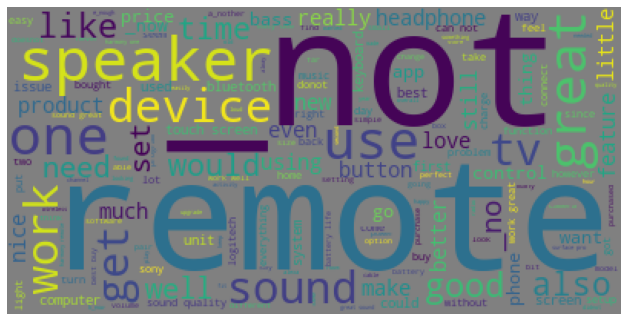

In [47]:
#Слова встречающиеся во всех отзывах
text_raw = " ".join(freqWordsAllRew[0])
wordcloud = WordCloud(background_color='grey', max_words=2000, stopwords='english').generate(text_raw)
plt.figure(figsize=(11,9))
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

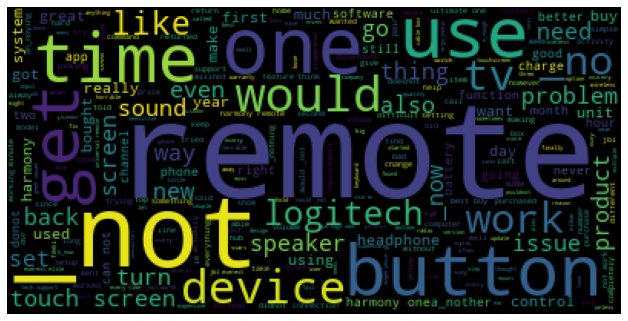

In [48]:
#Слова встречающиеся в отрицательных отзывах
text_raw = " ".join(freqWordsNegRew[0])
wordcloud = WordCloud(background_color='black', max_words=2000, stopwords='english').generate(text_raw)
plt.figure(figsize=(11,9))
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

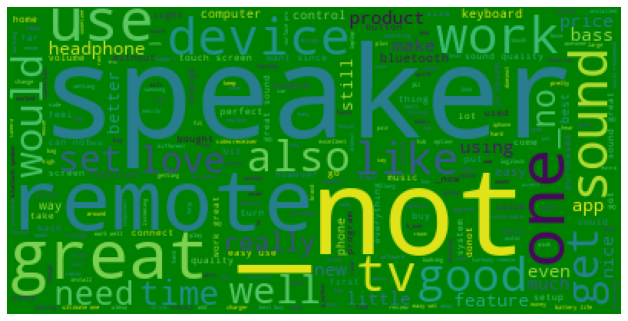

In [49]:
#Слова встречающиеся во всех отзывах
text_raw = " ".join(freqWordsPosRew[0])
wordcloud = WordCloud(background_color='green', max_words=2000, stopwords='english').generate(text_raw)
plt.figure(figsize=(11,9))
plt.imshow(wordcloud)
plt.axis('off')

##### Boosting Model

Бустинг - процедура последовательного построения композиции алгоритмов машинного обучения, когда каждый следующий алгоритм стремится компенсировать недостатки композиции всех предыдущих алгоритмов.

In [50]:

# import xgboost

# # Extereme Gradient Boosting на Count Vectors
# model_predict_count = train_model(xgboost.XGBClassifier(), xtrain_count, train_y, xvalid_count, valid_y)
# print("XGB, Count Vectors predict the rating: ", model_predict_count.predict(count_vect.transform([df['textNew'][r_num]])))
# print('='*100)

# # Extereme Gradient Boosting на Word Level TF IDF Vectors
# model_predict_tfidf_word = train_model(xgboost.XGBClassifier(), xtrain_tfidf, train_y, xvalid_tfidf, valid_y)
# print("XGB, WordLevel TF-IDF predict the rating: ", model_predict_tfidf_word.predict(tfidf_vect.transform([df['textNew'][r_num]])))
# print('='*100)

# # Extereme Gradient Boosting на Ngram Level TF IDF Vectors
# model_predict_tfidf_ngram = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y)
# print("XGB, N-Gram Vectors predict the rating: ", model_predict_tfidf_ngram.predict(tfidf_vect_ngram.transform([df['textNew'][r_num]])))
# print('='*100)

# # Extereme Gradient Boosting на Character Level TF IDF Vectors
# model_predict_tfidf_chars = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y)
# print("XGB, CharLevel Vectors: ", model_predict_tfidf_chars.predict(tfidf_vect_ngram_chars.transform([df['textNew'][r_num]])))
# print('='*100)


####Naive Bayes

Наивный Байес - это метод классификации, основанный на теореме Байеса с допущением независимости между предикторами. Наивный байесовский классификатор предполагает, что наличие определенного признака в классе не связано с наличием какого-либо другого признака в нем.

In [51]:

# # Naive Bayes на Count Vectors
# model_predict_count = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count, valid_y)
# print("NBayes, Count Vectors predict the rating: ", model_predict_count.predict(count_vect.transform([df['textNew'][r_num]])))
# print('='*100)

# # Naive Bayes на Word Level TF IDF Vectors
# model_predict_tfidf_word = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf, valid_y)
# print("NBayes, WordLevel TF-IDF predict the rating: ", model_predict_tfidf_word.predict(tfidf_vect.transform([df['textNew'][r_num]])))
# print('='*100)

# # Naive Bayes на Ngram Level TF IDF Vectors
# model_predict_tfidf_ngram = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y)
# print("NBayes, N-Gram Vectors predict the rating: ", model_predict_tfidf_ngram.predict(tfidf_vect_ngram.transform([df['textNew'][r_num]])))
# print('='*100)

# # Naive Bayes на Character Level TF IDF Vectors
# model_predict_tfidf_chars = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y)
# print("NBayes, CharLevel Vectors: ", model_predict_tfidf_chars.predict(tfidf_vect_ngram_chars.transform([df['textNew'][r_num]])))
# print('='*100)


######RandomForest

Cлучайный лес - ансамбль решающих деревьев.

In [52]:

# # RandomForest Classifier на Count Vectors
# model_predict_count = train_model(ensemble.RandomForestClassifier(n_estimators=200, random_state=42), xtrain_count, train_y, xvalid_count, valid_y)
# print("RForest, Count Vectors predict the rating: ", model_predict_count.predict(count_vect.transform([df['textNew'][r_num]])))
# print('='*100)

# # RandomForest Classifier на Word Level TF IDF Vectors
# model_predict_tfidf_word = train_model(ensemble.RandomForestClassifier(n_estimators=200, random_state=42), xtrain_tfidf, train_y, xvalid_tfidf, valid_y)
# print("RForest, WordLevel TF-IDF predict the rating: ", model_predict_tfidf_word.predict(tfidf_vect.transform([df['textNew'][r_num]])))
# print('='*100)

# # RandomForest Classifier на Ngram Level TF IDF Vectors
# model_predict_tfidf_ngram = train_model(ensemble.RandomForestClassifier(n_estimators=200, random_state=42), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y)
# print("RForest, N-Gram Vectors predict the rating: ", model_predict_tfidf_ngram.predict(tfidf_vect_ngram.transform([df['textNew'][r_num]])))
# print('='*100)

# # RandomForest Classifier на Character Level TF IDF Vectors
# model_predict_tfidf_chars = train_model(ensemble.RandomForestClassifier(n_estimators=200, random_state=42), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y)
# print("RForest, CharLevel Vectors: ", model_predict_tfidf_chars.predict(tfidf_vect_ngram_chars.transform([df['textNew'][r_num]])))
# print('='*100)


##### SVM

SVM -  алгоритм машинного обучения с учителем, который может быть использован как для классификации, так и для регрессии. Модель извлекает наилучшую возможную гиперплоскость/линию, которая разделяет эти два класса.

In [53]:

# # SVM на Count Vectors
# model_predict_count = train_model(svm.SVC(), xtrain_count, train_y, xvalid_count, valid_y)
# print("SVM, Count Vectors predict the rating: ", model_predict_count.predict(count_vect.transform([df['textNew'][r_num]])))
# print('='*100)

# # SVM на Word Level TF IDF Vectors
# model_predict_tfidf_word = train_model(svm.SVC(), xtrain_tfidf, train_y, xvalid_tfidf, valid_y)
# print("SVM, WordLevel TF-IDF predict the rating: ", model_predict_tfidf_word.predict(tfidf_vect.transform([df['textNew'][r_num]])))
# print('='*100)

# # SVM на Ngram Level TF IDF Vectors
# model_predict_tfidf_ngram = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y)
# print("SVM, N-Gram Vectors predict the rating: ", model_predict_tfidf_ngram.predict(tfidf_vect_ngram.transform([df['textNew'][r_num]])))
# print('='*100)

# # SVM на Character Level TF IDF Vectors
# model_predict_tfidf_chars = train_model(svm.SVC(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y)
# print("SVM, CharLevel Vectors: ", model_predict_tfidf_chars.predict(tfidf_vect_ngram_chars.transform([df['textNew'][r_num]])))
# print('='*100)
